In [118]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
import astropy.coordinates as coords
import astropy.units as u
from astropy.nddata import Cutout2D
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from regions import Regions
import yaml
import warnings
from hidefutils import jy_to_cm2, totflux, himass

In [122]:
chan_range = {16: [3486.1, 4278.1], #[128, 268],
              31: [3849.6, 4444.7], #[270, 375],
              91: [7508.3, 6613.0]} #[595, 750]}
distances = {16: 49.0,
             31: 53.0,
             91: 92.0}


In [532]:
# def jy_to_cm2(data,hdr):
#     '''
#     Convert moment 0 map into column density
#     Parameters
#     ----------
#     data: HDU data array
#     hdr: HDU header
#     '''
#     bunit = hdr['BUNIT']
#     if bunit.lower() in ['jy/beam.m/s', 'jy/beam*m/s']:
#         fac = 1.249e21
#     elif bunit.lower().replace(' ','') in ['jy/beam.km/s', 'jy/beam*km/s', 'beam-1jykms-1']:
#         fac = 1.249e24
#     else:
#         fac = 1.249e24
#         print('check moment 0 units, considering "Jy/beam.km/s" but could be wrong')
#     bmaj, bmin = hdr['BMAJ'] * 3600., hdr['BMIN'] * 3600.
#     beam_area = bmaj * bmin * np.pi / (4.0 * np.log(2.0))
#     nhi = fac * data / beam_area
#     return nhi

# def totflux(data, hdr):
#     '''Calculate total flux from an HDU
#     Parameters
#     ----------
#     data: HDU data array
#     hdr: HDU header
#     '''
#     cell_size = abs(hdr['CDELT1'])
#     cell_area = cell_size * cell_size
#     bmaj, bmin = hdr['BMAJ'], hdr['BMIN']
#     beam_area = bmaj * bmin * np.pi / (4.0 * np.log(2.0) * cell_area)
#     box = data.copy()
#     sdv = np.nansum(box) / beam_area ### conversion from Jy/beam.km/s to Jy.km/s
#     bunit = hdr['BUNIT']
#     if bunit.lower().replace(' ','') in ['jy/beam.m/s', 'jy/beam*m/s', 'beam-1jyms-1']: ### convert from Jy/beam.m/s to Jy/beam.km/s
#         sdv *= 1e-3
#     return sdv

# def himass(f, D):
#     '''Calculate HI mass from flux f (Jy.km/s) and distance D (Mpc)
#     Parameters
#     ----------
#     f: flux in Jy.km/s
#     D: distance in Mpc
#     '''
#     m = 2.36e5 * D**2 * f
#     return np.log10(m)

In [ ]:
 def calculate_individual_masses(hcg, show_plot=False):
    '''
    Calculate MHI of Phase 2 HCGs individual member galaxies discs and plot their contours on an optical image.
    Returns a Pandas dataframe containing the HI masses of the member galaxies.
    '''
    warnings.filterwarnings(action='ignore', category=UserWarning)
    mydir = 'slicerastro_output/'
    colors = ['w', 'b', 'cyan', 'magenta', 'yellow']
    with open('/mnt/scratch/HCGs/separate_hi_discs/ids_to_galnames.yml') as fp:
        ids_to_galnames = yaml.safe_load(fp)
    id_to_galname = ids_to_galnames[f'HCG {hcg}']
    opt_d, opt_h = fits.getdata(f'legacy_images/HCG{hcg}_grz.fits', header=True)
    if hcg == 31:
        suffix = '_15as'
    else:
        suffix = ''    
    cube = SpectralCube.read(f'/mnt/scratch/HCGs/separate_hi_discs/hcg{hcg}_cropped{suffix}.fits')
    cube_kms = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1420405752*u.Hz)
    mask_array = fits.getdata(f'/mnt/scratch/HCGs/separate_hi_discs/slicerastro_output/hcg{hcg}_all{suffix}_mask.fits')
    raw_mask_array = fits.getdata(f'/mnt/scratch/HCGs/separate_hi_discs/hcg{hcg}_mask_cropped{suffix}.fits')
    if len(raw_mask_array.shape) > 3:
        raw_mask_array = raw_mask_array[0]
    reg = Regions.read(f'/mnt/scratch/HCGs/separate_hi_discs/box_hcg{hcg}.reg', format='crtf')
    if len(reg) == 1:
        ccoo = reg[0].center
        width, height = reg[0].width, reg[0].height

    cutout = Cutout2D(opt_d[0], position=ccoo, size=(height,width), wcs=WCS(opt_h).celestial)
    r, wcs = cutout.data, cutout.wcs
    vmin=np.nanmedian(r)-0.05*np.nanstd(r)
    vmax=np.nanmedian(r)+0.1*np.nanstd(r)
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection=wcs.celestial)
    ax.imshow(r, vmin=vmin, vmax=vmax, cmap='gray_r')

    all_hi_mask = raw_mask_array > 0.
    all_hi = cube_kms.with_mask(all_hi_mask)
    # igm_mask = mask_array == 0.
    # igm_cube = all_hi.with_mask(igm_mask)
    # igm_m0 = igm_cube.moment(order=0)
    # levels = [6.6e18 * 2**x for x in range(15)]
    # igm_nhi = jy_to_cm2(igm_m0.hdu.data, igm_m0.hdu.header)
    # igm_nhi[np.isnan(igm_nhi)] == 0.
    all_hi_m0 = all_hi.moment(order=0)
    levels = [6.6e18 * 2**x for x in range(15)]
    all_hi_nhi = jy_to_cm2(all_hi_m0.hdu.data, all_hi_m0.hdu.header)
    all_hi_nhi[np.isnan(all_hi_nhi)] == 0.
    ax.contour(all_hi_nhi, levels=levels, colors='k', linewidths=0.7, transform=ax.get_transform(all_hi_m0.wcs))
    mhi_tot = 0.
    df = pd.DataFrame(columns=['HCG', 'member', 'logMHI'])
    
    ### Solve dimension mismatch issue between mask and data (106 vs 107) for HCG 31
    if hcg == 31:
        nan_plane = np.full((1, mask_array.shape[1], mask_array.shape[2]), np.nan)
        mask_array = np.concatenate((mask_array, nan_plane), axis=0)

    for i, key in enumerate(id_to_galname.keys()):
        mask = mask_array == float(key)
        masked_cube = cube_kms.with_mask(mask)
        m0 = masked_cube.moment(order=0)
        galname = id_to_galname[key].lower().replace(' ','')
        m0.hdu.writeto(f'/mnt/scratch/HCGs/separate_hi_discs/hcg{hcg}_mom0_{galname}.fits', overwrite=True)
        m0_data = m0.hdu.data
        flux = totflux(m0_data, m0.hdu.header)
        mhi = himass(flux, distances[hcg])
        mhi_tot += 10**mhi
        nhi_data = jy_to_cm2(m0_data, m0.hdu.header)
        nhi_data[np.isnan(nhi_data)] = 0
        ax.contour(nhi_data, levels=levels, colors=colors[int(key)-1], linewidths=1, transform=ax.get_transform(m0.wcs))
        df.loc[i] = [hcg, galname.upper().replace('HCG',''), mhi]
    #     print(f'{galname.upper()}: {mhi:.1f}')
    df.loc[i+1] = [hcg, 'total', np.log10(mhi_tot)]
    # print(f'Total: {np.log10(mhi_tot): .2f}')
    ax.coords[0].set_axislabel('RA (J2000)'); ax.coords[1].set_axislabel('Dec (J2000)')
    if hcg == 31:
        ax.set_xlim((0.5*r.shape[1]-0.25*r.shape[1]), (0.5*r.shape[1]+0.25*r.shape[1]))
        ax.set_ylim((0.5*r.shape[0]-0.25*r.shape[0]), (0.5*r.shape[0]+0.25*r.shape[0]))
    plt.savefig(f'/mnt/scratch/HCGs/maps_figures/hcg{hcg}_core_members{suffix}.pdf')
    df.to_csv('/mnt/scratch/HCGs/individual_masses_hcg{hcg}.csv')
    if show_plot:
        plt.show()
    else:
        plt.clf()
    return df

In [ ]:
 def plot_moment_maps_hires(hcg, show_plot=False):
    warnings.filterwarnings(action='ignore', category=UserWarning)
    mydir = 'slicerastro_output/'
    colors = ['w', 'b', 'cyan', 'magenta', 'yellow']
    with open('/mnt/scratch/HCGs/separate_hi_discs/ids_to_galnames.yml') as fp:
        ids_to_galnames = yaml.safe_load(fp)
    id_to_galname = ids_to_galnames[f'HCG {hcg}']
    opt_d, opt_h = fits.getdata(f'/mnt/scratch/HCGs/legacy_images/HCG{hcg}_grz.fits', header=True)
    cube = SpectralCube.read(f'/mnt/scratch/HCGs/separate_hi_discs/hcg{hcg}_cropped_15as.fits')
    cube_kms = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1420405752*u.Hz)
    mask_array = fits.getdata(f'/mnt/scratch/HCGs/separate_hi_discs/slicerastro_output/hcg{hcg}_all_15as_mask.fits')
    raw_mask_array = fits.getdata(f'/mnt/scratch/HCGs/separate_hi_discs/hcg{hcg}_mask_cropped_15as.fits')
    if len(raw_mask_array.shape) > 3:
        raw_mask_array = raw_mask_array[0]
    reg = Regions.read(f'/mnt/scratch/HCGs/separate_hi_discs/box_hcg{hcg}.reg', format='crtf')
    if len(reg) == 1:
        ccoo = reg[0].center
        width, height = reg[0].width, reg[0].height

    cutout = Cutout2D(opt_d[0], position=ccoo, size=(height,width), wcs=WCS(opt_h).celestial)
    r, wcs = cutout.data, cutout.wcs
    vmin=np.nanmedian(r)-0.05*np.nanstd(r)
    vmax=np.nanmedian(r)+0.1*np.nanstd(r)
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection=wcs.celestial)
    ax.imshow(r, vmin=vmin, vmax=vmax, cmap='gray_r')

    all_hi_mask = raw_mask_array > 0.
    all_hi = cube_kms.with_mask(all_hi_mask)
    all_hi_m0 = all_hi.moment(order=0)
    levels = [6.6e18 * 2**x for x in range(15)]
    all_hi_nhi = jy_to_cm2(all_hi_m0.hdu.data, all_hi_m0.hdu.header)
    all_hi_nhi[np.isnan(all_hi_nhi)] == 0.
    ax.contour(all_hi_nhi, levels=levels, colors='k', linewidths=0.7, transform=ax.get_transform(all_hi_m0.wcs))
    mhi_tot = 0.
    df = pd.DataFrame(columns=['HCG', 'member', 'logMHI'])
    # print('HI masses (logMsun):')
    
    ### Solve dimension mismatch issue between mask and data (106 vs 107)
    nan_plane = np.full((1, mask_array.shape[1], mask_array.shape[2]), np.nan)
    mask_array = np.concatenate((mask_array, nan_plane), axis=0)
    
    for i, key in enumerate(id_to_galname.keys()):
        mask = mask_array == float(key)
        masked_cube = cube_kms.with_mask(mask)
        m0 = masked_cube.moment(order=0)
        galname = id_to_galname[key].lower().replace(' ','')
        m0.hdu.writeto(f'/mnt/scratch/HCGs/separate_hi_discs/hcg{hcg}_mom0_{galname}.fits', overwrite=True)
        m0_data = m0.hdu.data
        flux = totflux(m0_data, m0.hdu.header)
        mhi = himass(flux, distances[hcg])
        mhi_tot += 10**mhi
        nhi_data = jy_to_cm2(m0_data, m0.hdu.header)
        nhi_data[np.isnan(nhi_data)] = 0
        ax.contour(nhi_data, levels=levels, colors=colors[int(key)-1], linewidths=1, transform=ax.get_transform(m0.wcs))
        df.loc[i] = [hcg, galname.upper().replace('HCG',''), mhi]
        # print(f'{galname.upper()}: {mhi:.1f}')
    df.loc[i+1] = [hcg, 'total', np.log10(mhi_tot)]
    # print(f'Total: {np.log10(mhi_tot): .2f}')
    ax.coords[0].set_axislabel('RA (J2000)'); ax.coords[1].set_axislabel('Dec (J2000)')
    ax.set_xlim((0.5*r.shape[1]-0.25*r.shape[1]), (0.5*r.shape[1]+0.25*r.shape[1]))
    ax.set_ylim((0.5*r.shape[0]-0.25*r.shape[0]), (0.5*r.shape[0]+0.25*r.shape[0]))
    plt.savefig(f'/mnt/scratch/HCGs/maps_figures/hcg{hcg}_core_members_15as.pdf')
    df.to_csv(f'/mnt/scratch/HCGs/individual_masses_hcg{hcg}.csv')
    if show_plot:
        plt.show()
    else:
        plt.clf()
    return df

In [940]:
df = pd.DataFrame()
for hcg in [16, 31, 91]:
    if hcg == 31:
        df_ = plot_moment_maps_hires(hcg)
    else:
        df_ = plot_moment_maps(hcg)
    df = df._append(df_, ignore_index=True)

check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s"

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong


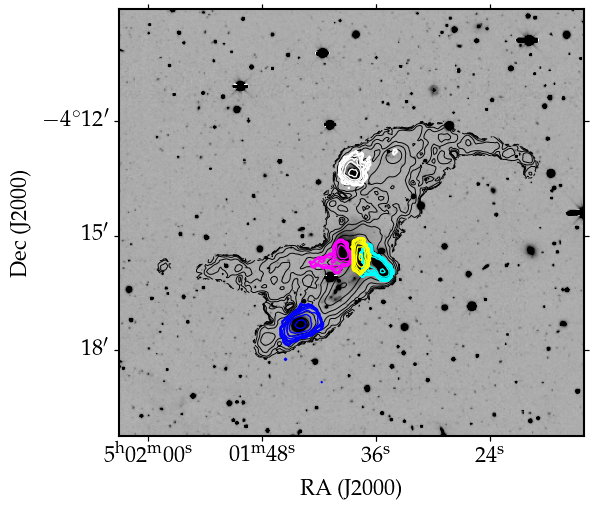

,HCG,member,logMHI
0,31,31Q,8.468373
1,31,31B,8.945310
2,31,31C,8.808641
3,31,31A,8.538609
4,31,31G,8.607776
5,31,total,9.409977


In [953]:
plot_moment_maps(31, show_plot=True)

In [156]:
header = '\\begin{table}\n\
\\begin{center}\n\
\\caption{\\hi\ masses of the members of Phase 2 groups. The last two columns respectively list the \hi\ masses inside and outside the discs of the galaxies.}\
\\label{tab:mems_phase2}\n\
\\begin{tabular}{l l c c} \n\
\\hline \n\
\\hline \n\
\\multirow{2}{*}{HCG} & \\multirow{2}{*}{member} & $\\rm\log{M_{\\textsc{Hi}, gal}}$ & $\\rm\log{M_{\hi,ext}}$ \\\\ \n\
 & & $\\rm (M_\odot)$ & $\\rm (M_\odot)$ \\\\ \n\
\\hline \\rule{0pt}{10pt}\n'
fout = open('/mnt/scratch/HCGs/tables/tab_mems_phase2.tex', 'w')
fout.write(header)

gs = [16, 31, 91]
df_ = df.groupby('HCG')

for g in gs:
    dfg = df_.get_group(g)
    dfg.reset_index().drop(columns='index', inplace=True)
    dfg = dfg.sort_values(by='member', ignore_index=True)
    df_pars = pd.read_csv(f'/mnt/scratch/HCGs/params_tables/HIdef_hcg{g}.csv')
    df_pars.dropna(subset=['Name'], inplace=True)
    mtot = 10**df_pars[df_pars.Name=='core: total'].logMHIobs.values[0]
    for i,row in dfg.iterrows():
        row.member = row.member.replace('WJ','WJ$^*$')
        if i == 0:
            line = ' \\rule{0pt}{10pt}\n\\multirow{%d}{*}{%d} & %s & %.1f & --\\\\ \n' %(len(dfg),g,row.member.replace('NGC','N').replace('AD','A'),row.logMHI)
        elif i == len(dfg)-1:
            mgal = 10**row.logMHI
            mgas = np.log10(mtot - mgal)
            line = ' & {\\bf %s galaxies} & {\\bf %.1f} & {\\bf %.1f}\\\\ \n' %(row.member,row.logMHI, mgas)
        else:
            line = ' & %s & %.1f & -- \\\\ \n' %(row.member.replace('NGC','N').replace('AD','A'),row.logMHI)
        fout.write(line)
    fout.write('\\hline\n')
fout.write('\\end{tabular} \\\\ \n\
\\rule{0pt}{10pt}\n\
Note: $^*$WISEA J220854.95-274701.6 coincides spatially with the peak of an \hi\ cloud in the core of HCG 91, \
but lacks an optical readshift; we include it in this table but do not count it as a core member.\n\
\\end{center} \n\
\\end{table}')
fout.close()

In [146]:
# x = 10**df_pars[df_pars.Name=='core: total'].logMHIobs.values[0]
# x - 10**row.logMHI
# df_pars[df_pars.Name=='core: total'].logMHIobs.values
df_pars

,Unnamed: 0,HCG,Name,RA,Dec,Vsys,M_type,T_type,sep_kpc,sep_norm,...,HIflag,MHIlim_flag,gmag,e_gmag,rmag,e_rmag,Btot,logLB,logMs,e_logMs
0,0,91.0,WISEA J220943.70-273554.8,332.432250,-27.598920,7072.0,S0,-2.0,373.478,0.793,...,1.0,0.0,18.740,0.062,18.106,0.045,18.513,8.475,8.973,0.081
1,1,91.0,ESO 467- G 016,332.459250,-27.535610,7372.0,Sa,1.0,480.281,1.019,...,1.0,0.0,14.861,0.003,14.229,0.002,14.633,10.026,10.554,0.011
2,2,91.0,ESO 467- G 014,332.309430,-27.403220,7112.5,SBc,5.0,628.598,1.334,...,1.0,0.0,15.897,0.008,15.669,0.009,15.512,9.675,9.534,0.016
6,6,91.0,ESO 467- G 003,331.560830,-27.958390,6975.0,SBbc,4.0,1067.604,2.266,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,91.0,ESO 467- G 005,331.641250,-27.991580,6868.5,Sb,3.0,973.285,2.066,...,1.0,0.0,15.465,0.006,14.951,0.004,15.192,9.803,10.129,0.013
8,8,91.0,ESO 532- G 023,332.404500,-27.246500,7235.0,SBbc,4.0,894.672,1.899,...,1.0,0.0,15.192,0.006,14.678,0.005,14.918,9.912,10.287,0.013
9,9,91.0,WISEA J221035.73-271456.0,332.648750,-27.248970,7180.0,S0,-2.0,1013.967,2.152,...,1.0,0.0,16.961,0.013,16.566,0.473,16.641,9.223,9.378,0.496
10,10,91.0,GALEXASC J220922.12-271623.9,332.341900,-27.273400,5851.0,Im,10.0,839.717,1.782,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,11,91.0,WISEA J221040.40-274144.2,332.668250,-27.695730,6814.0,Sd,7.0,560.714,1.190,...,1.0,0.0,18.351,0.028,17.944,0.020,18.036,8.665,8.844,0.037
12,12,91.0,WISEA J220659.01-271620.4,331.746220,-27.271770,6931.0,Im,10.0,1141.435,2.422,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
masked_cube_kms = masked_cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1420405752*u.Hz)
moment_0 = masked_cube_kms.moment(order=0)

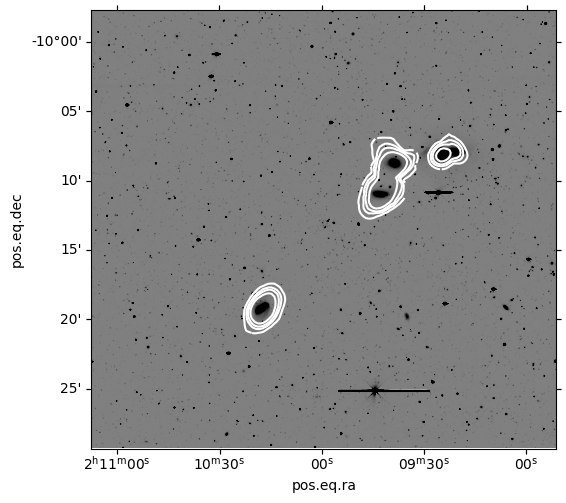

In [41]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection=wcs.celestial)
ax.imshow(r, vmin=vmin, vmax=vmax, cmap='gray_r')
ax.contour(moment_0, levels=[0.1, 0.3, 0.5, 0.9], colors='w', transform=ax.get_transform(moment_0.wcs));